In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# Data analysis

In [2]:
df = pd.read_csv("./data/SeoulBikeData.csv", encoding='unicode_escape')
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

No null values

In [4]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

<Axes: xlabel='Temperature(°C)', ylabel='Rented Bike Count'>

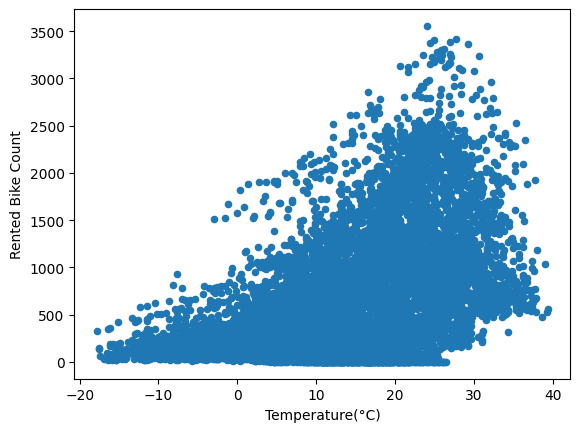

In [5]:
df[['Temperature(°C)', 'Rented Bike Count']].plot(x='Temperature(°C)', y='Rented Bike Count', kind='scatter')

As expected the demand is low when the temperature is low. Also the demand goes down when the temperature is too high.

<Axes: xlabel='Seasons', ylabel='Rented Bike Count'>

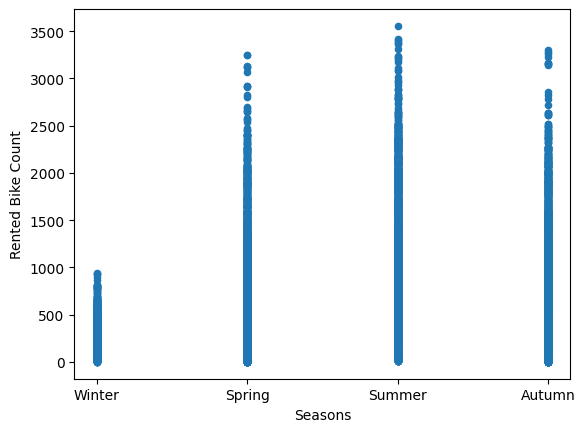

In [6]:
df[['Seasons', 'Rented Bike Count']].plot(x='Seasons', y='Rented Bike Count', kind='scatter')

<Axes: xlabel='Seasons'>

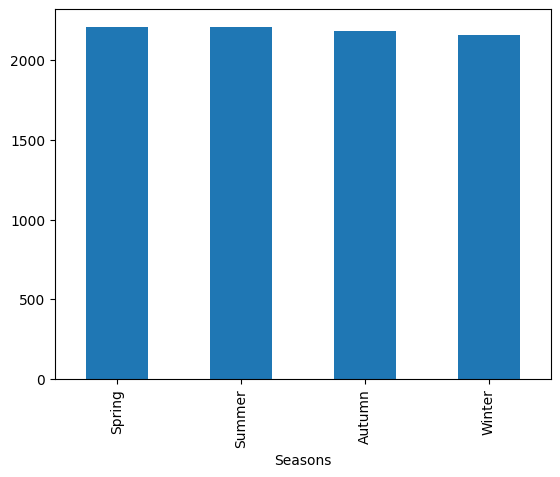

In [7]:
df['Seasons'].value_counts().plot(kind='bar')

Balanced distribution over seasons.

<Axes: xlabel='Hour', ylabel='Rented Bike Count'>

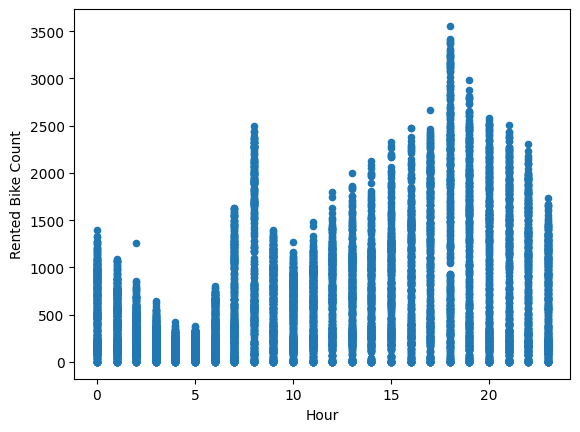

In [8]:
df[['Hour', 'Rented Bike Count']].plot(kind="scatter", x="Hour",y="Rented Bike Count")

Demand peaks in the morning and in the evening during commute hours.

<Axes: xlabel='Hour'>

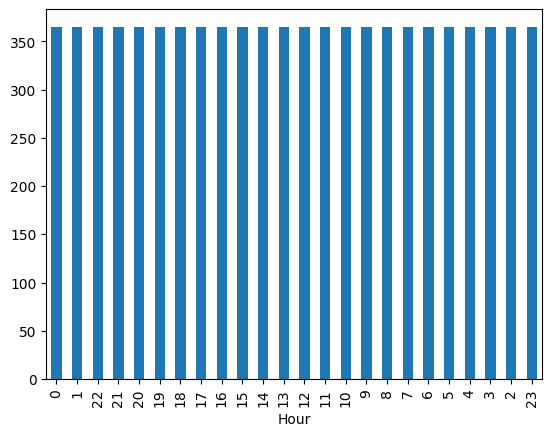

In [9]:
df['Hour'].value_counts().plot(kind="bar")

Balanced distribution over hours

<Axes: xlabel='Holiday', ylabel='Rented Bike Count'>

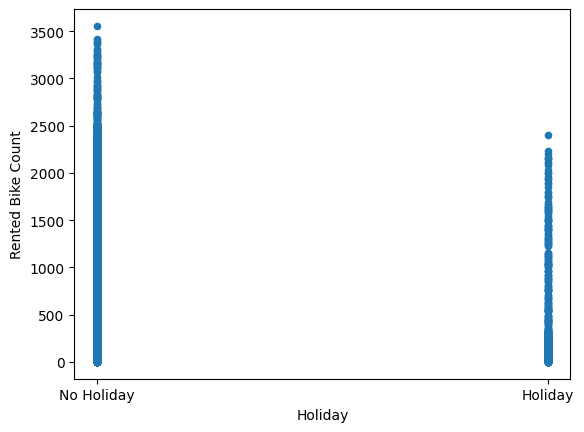

In [10]:
df[['Rented Bike Count', 'Holiday']].plot(kind="scatter", x="Holiday",y="Rented Bike Count")

Demand is higher on work days, which might be counterintuitive

<Axes: xlabel='Holiday'>

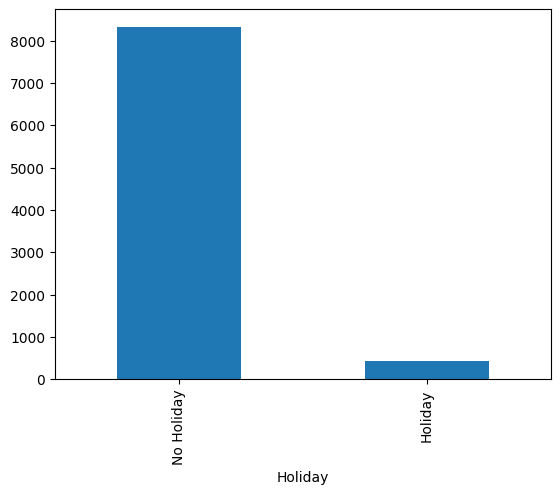

In [11]:
df['Holiday'].value_counts().plot(kind="bar")

<Axes: xlabel='Snowfall (cm)', ylabel='Rented Bike Count'>

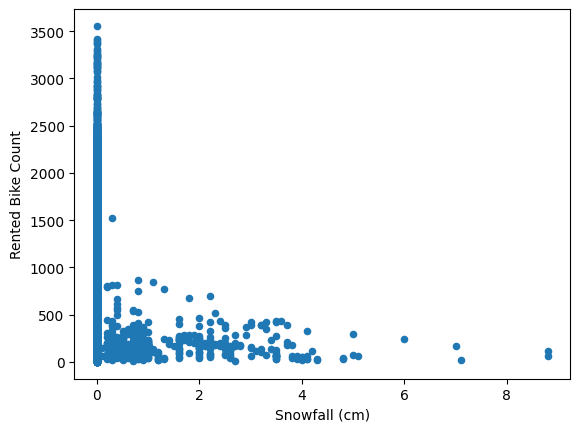

In [12]:
df[['Rented Bike Count', 'Snowfall (cm)']].plot(x='Snowfall (cm)', y='Rented Bike Count', kind="scatter")

<Axes: xlabel='Rainfall(mm)', ylabel='Rented Bike Count'>

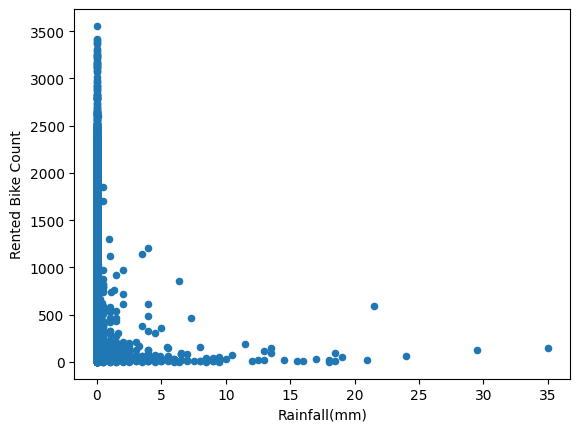

In [13]:
df[['Rented Bike Count', 'Rainfall(mm)']].plot(x='Rainfall(mm)', y='Rented Bike Count', kind="scatter")

# Preprocessing

In [14]:
season2nb = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}
nb2season = {0: 'Winter', 1: 'Spring', 2: 'Summer', 3: 'Autumn'}
df['Seasons'] = df['Seasons'].map(season2nb)
holiday2nb = {'No Holiday': 0, 'Holiday': 1}
nb2holiday = {0: 'No Holiday', 1: 'Holiday'}
df['Holiday'] = df['Holiday'].map(holiday2nb)
funcday2nb = {'No': 0, 'Yes': 1}
nb2funcday = {0: 'No', 1: 'Yes'}
df['Functioning Day'] = df['Functioning Day'].map(funcday2nb)
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,1
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,1
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,1
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,1
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,1


In [15]:
mask = df['Functioning Day'] == 0
cleaned = df.drop(df[mask].index)
cleaned = cleaned.drop(['Functioning Day'], axis=1)
cleaned.shape

(8465, 13)

In [16]:
cleaned['Day_of_Week'] = cleaned['Date'].dt.dayofweek
cleaned['Month'] = cleaned['Date'].dt.month
cleaned.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day_of_Week,Month
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,4,12
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,4,12
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,4,12
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,4,12
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,4,12


# Feature engineering

In [17]:
cleaned['demand_lag_1hr'] = cleaned['Rented Bike Count'].rolling(1, closed="left").mean()
cleaned.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day_of_Week,Month,demand_lag_1hr
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,0,0,4,12,NaN
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,0,0,4,12,254.0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,0,0,4,12,204.0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,0,0,4,12,173.0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,0,0,4,12,107.0


# Rescaling

In [18]:
scaler = StandardScaler()
standard_scale_features  = ['Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 
                            'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)']
cleaned[standard_scale_features ] = scaler.fit_transform(cleaned[standard_scale_features ])

scaler = MinMaxScaler()
min_max_scale_features  = ['Hour', 'Seasons', 'Day_of_Week', 'Month']
cleaned[min_max_scale_features] = scaler.fit_transform(cleaned[min_max_scale_features])
cleaned.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Day_of_Week,Month,demand_lag_1hr
0,2017-12-01,254,0.000000,-1.484762,-1.032395,0.458429,0.929577,-1.627067,-0.654079,-0.132495,-0.174951,0.0,0,0.666667,1.0,NaN
1,2017-12-01,204,0.043478,-1.509548,-0.983575,-0.895248,0.929577,-1.627067,-0.654079,-0.132495,-0.174951,0.0,0,0.666667,1.0,254.0
2,2017-12-01,173,0.086957,-1.550858,-0.934756,-0.701865,0.929577,-1.634619,-0.654079,-0.132495,-0.174951,0.0,0,0.666667,1.0,204.0
3,2017-12-01,107,0.130435,-1.567382,-0.885937,-0.798556,0.929577,-1.627067,-0.654079,-0.132495,-0.174951,0.0,0,0.666667,1.0,173.0
4,2017-12-01,78,0.173913,-1.550858,-1.081214,0.555121,0.929577,-1.702586,-0.654079,-0.132495,-0.174951,0.0,0,0.666667,1.0,107.0


# Train/test split

In [19]:
X = cleaned.drop(columns=['Rented Bike Count', 'Date'])
y = cleaned['Rented Bike Count']

In [20]:
train_indices = []
test_indices = []

for month in range(1, 13):
    month_data = cleaned[cleaned['Date'].dt.month == month]
    month_size = len(month_data)
    
    month_train_size = int(month_size * 0.9)
    month_test_size = month_size - month_train_size
    
    train_indices.extend(month_data.head(month_train_size).index)
    test_indices.extend(month_data.tail(month_test_size).index)


In [21]:
X_train = X.loc[train_indices]
X_test = X.loc[test_indices]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]

In [22]:
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)

X_train.shape =  (7613, 14)
X_test.shape =  (852, 14)


# Train models

In [23]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [24]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Evaluate

In [25]:
def print_eval_metrics(y_test, y_pred, model_name):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print("Metrics for", model_name)
    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("Root Mean Squared Error (RMSE):", rmse)
    print("R-squared (R2):", r2)
    
def plot_actual_predicted_by_month(y_test, y_pred, model_name):
    pred_df = pd.DataFrame({"Actual": list(y_test), "Predicted": list(y_pred), "Date": list(cleaned.loc[test_indices]['Date'])})
    grouped_data = pred_df.groupby(pred_df['Date'].dt.month)

    for month, group in grouped_data:
        group['Date'] = group['Date'].dt.date
        group.plot(figsize=(20, 5), title=f"{model_name} - {group['Date'].iloc[0].strftime('%B')}", x='Date', kind='bar')

In [26]:
y_pred_rf = rf.predict(X_test)
y_pred_xgb = xgb.predict(X_test)

print_eval_metrics(y_test, y_pred_rf, 'random forest')
print_eval_metrics(y_test, y_pred_xgb, 'xgb')

Metrics for random forest
Mean Absolute Error (MAE): 69.01171361502348
Mean Squared Error (MSE): 17633.78751431925
Root Mean Squared Error (RMSE): 132.79227204291388
R-squared (R2): 0.9549514266741219
Metrics for xgb
Mean Absolute Error (MAE): 68.82833921461598
Mean Squared Error (MSE): 15602.142833611968
Root Mean Squared Error (RMSE): 124.90853787316529
R-squared (R2): 0.9601416159228384


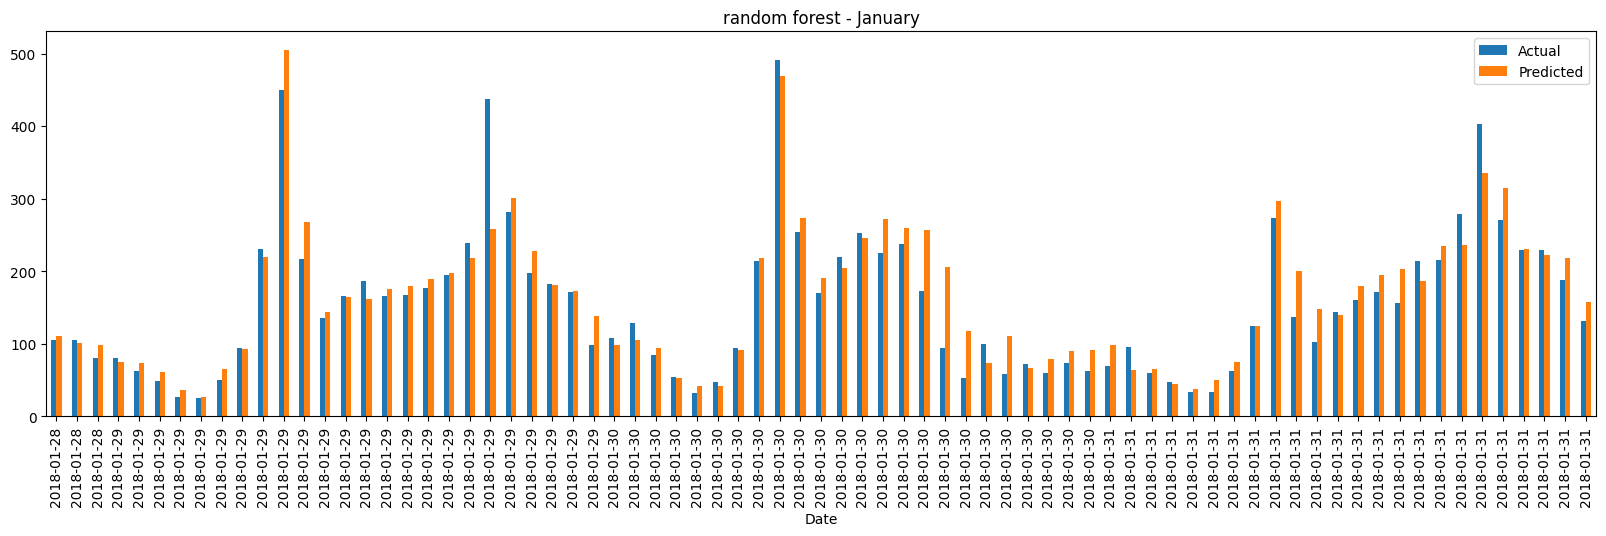

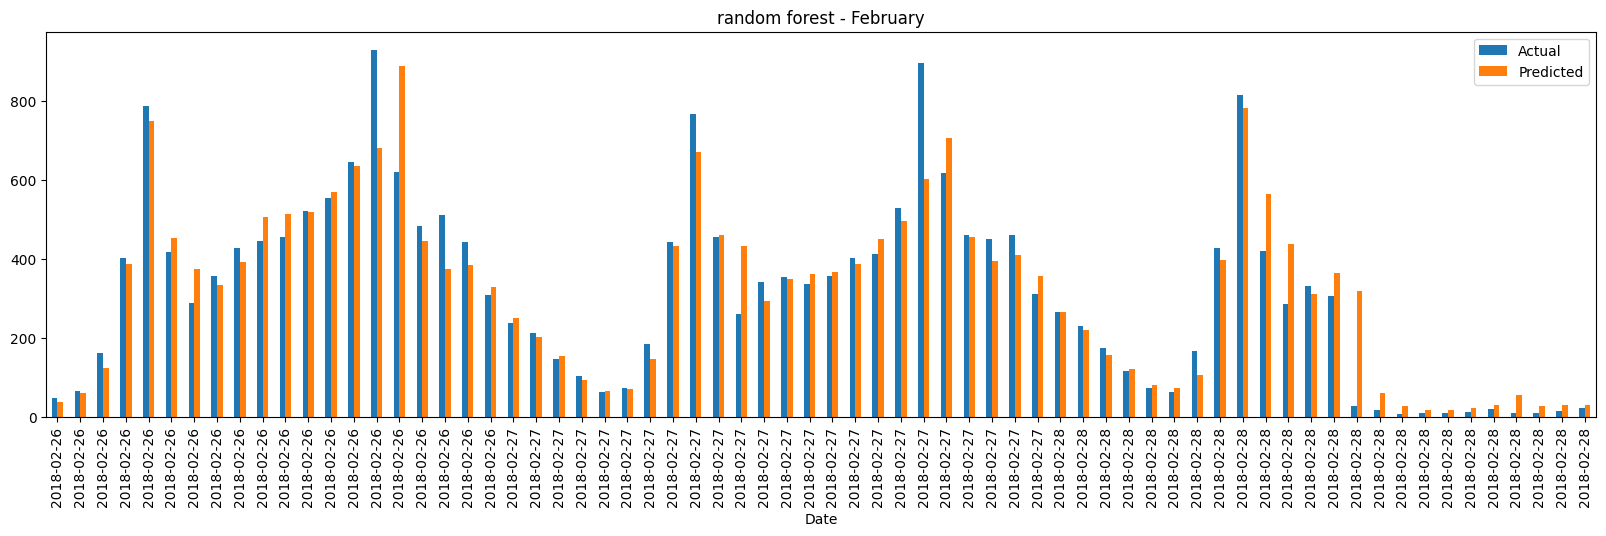

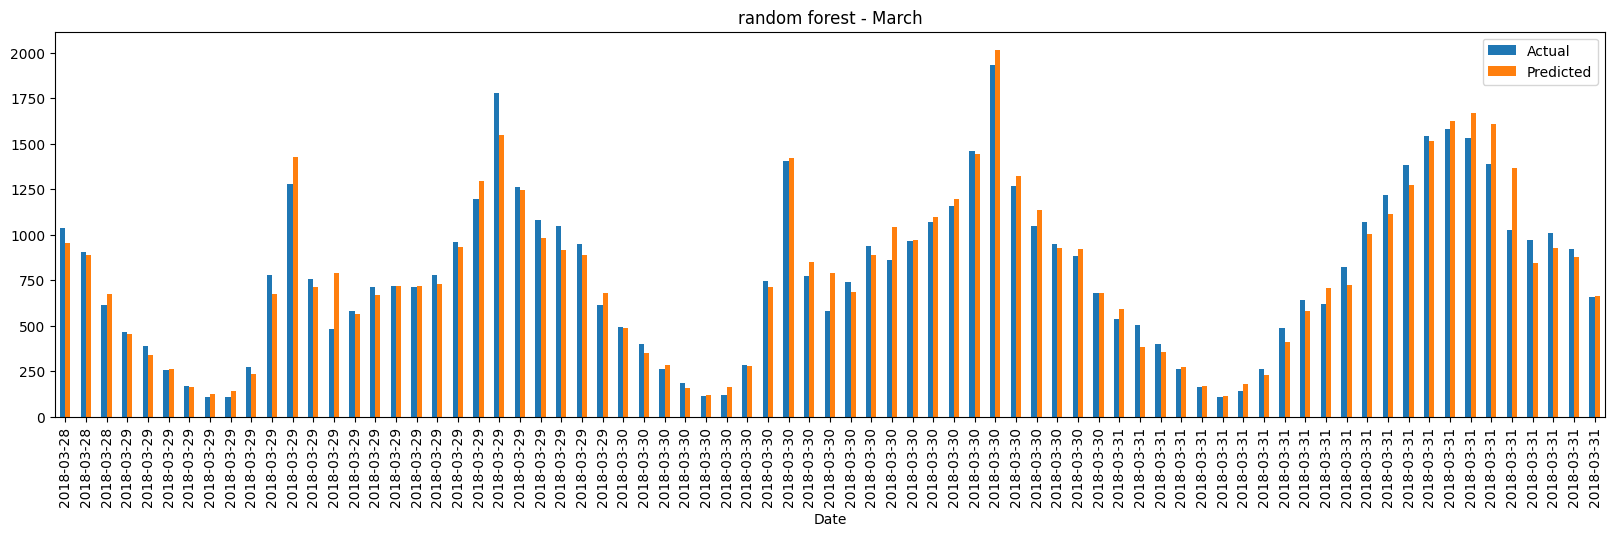

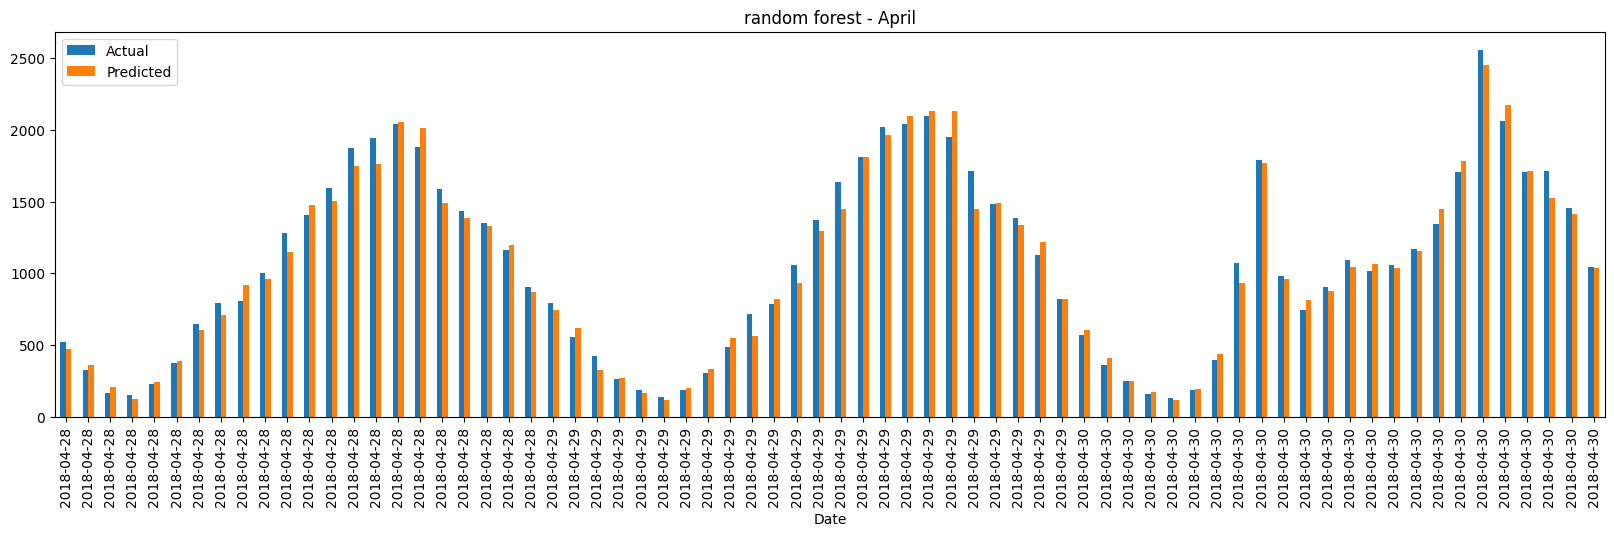

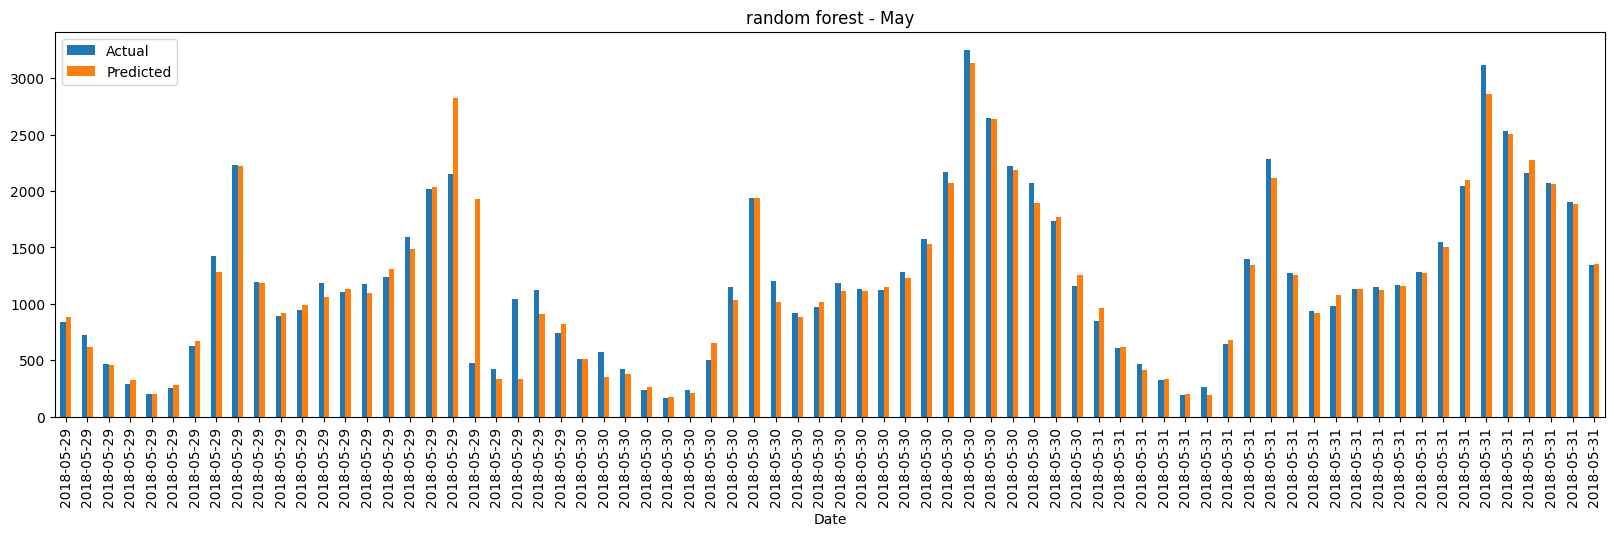

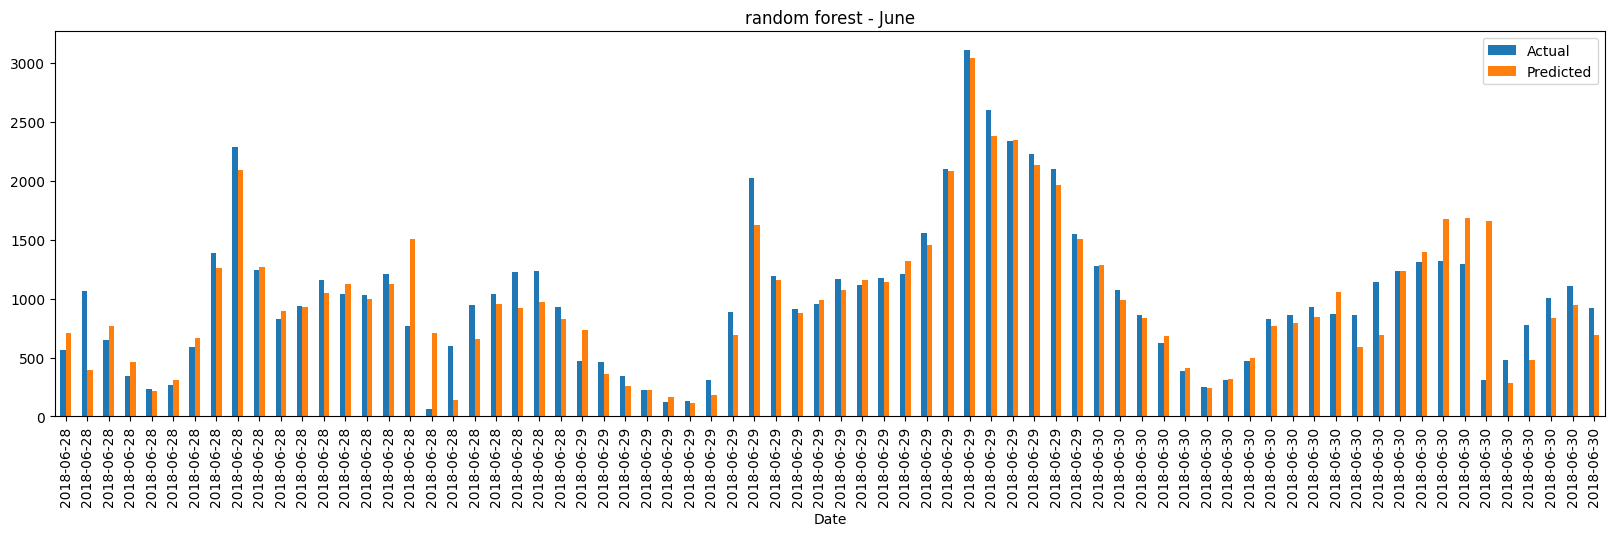

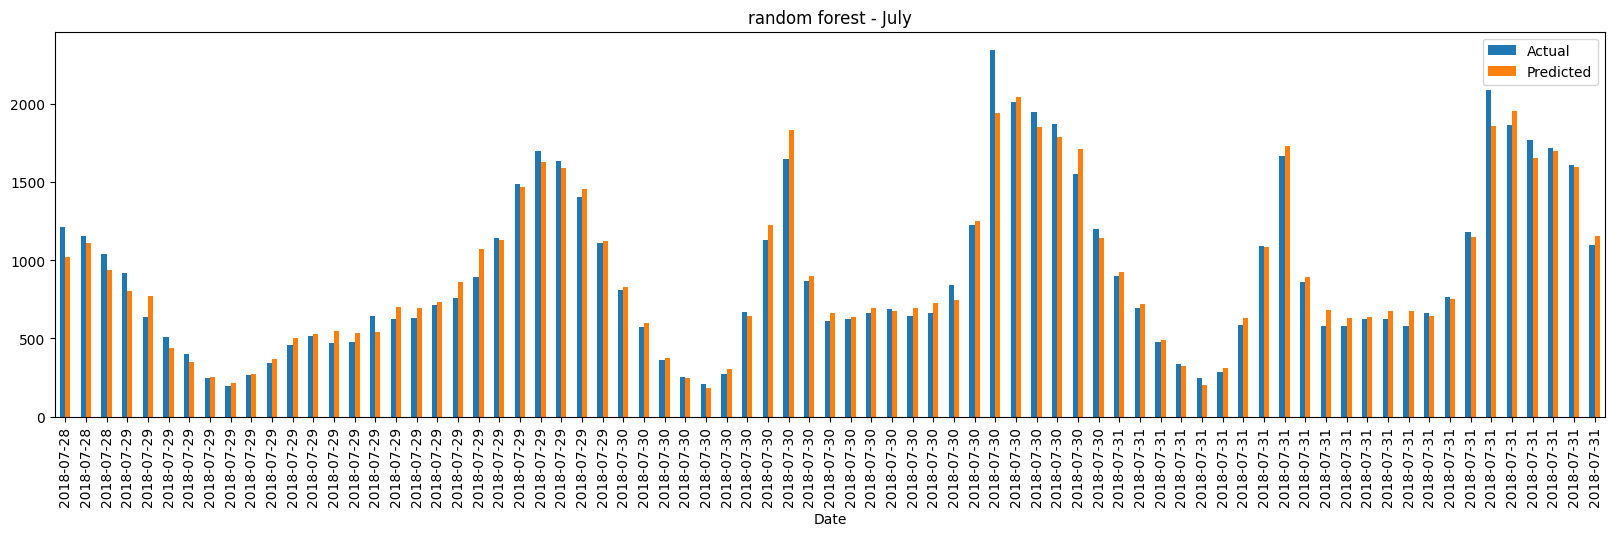

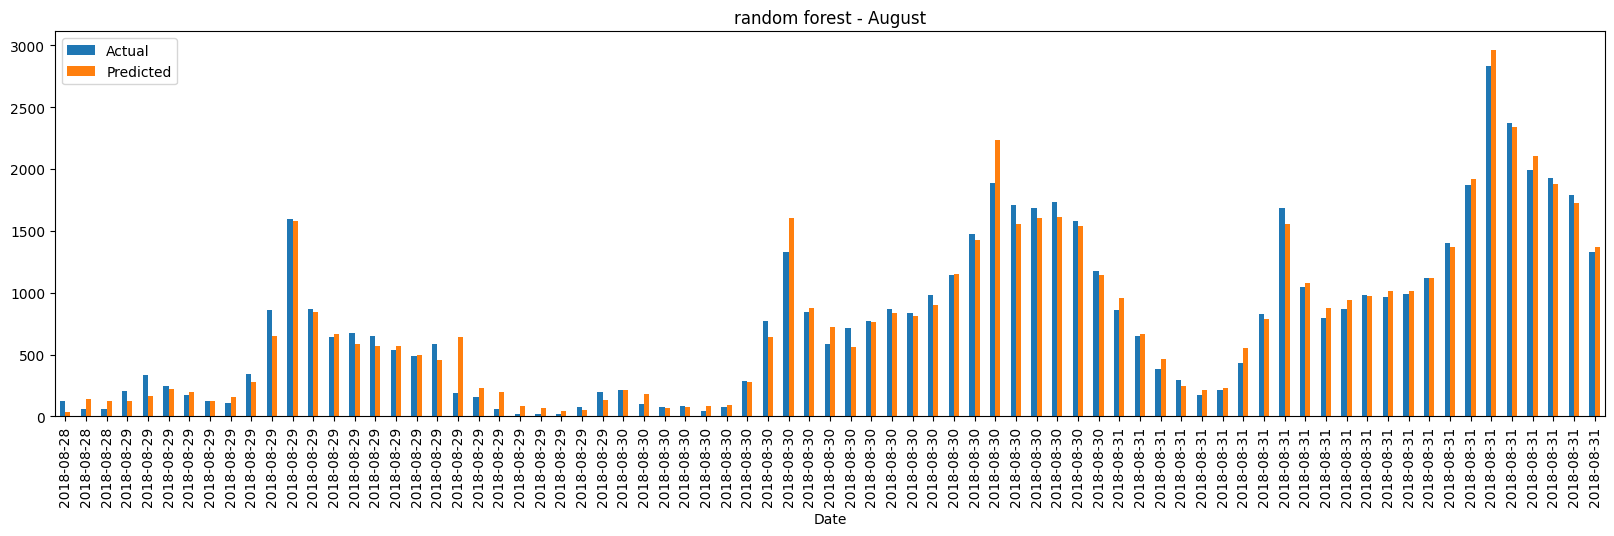

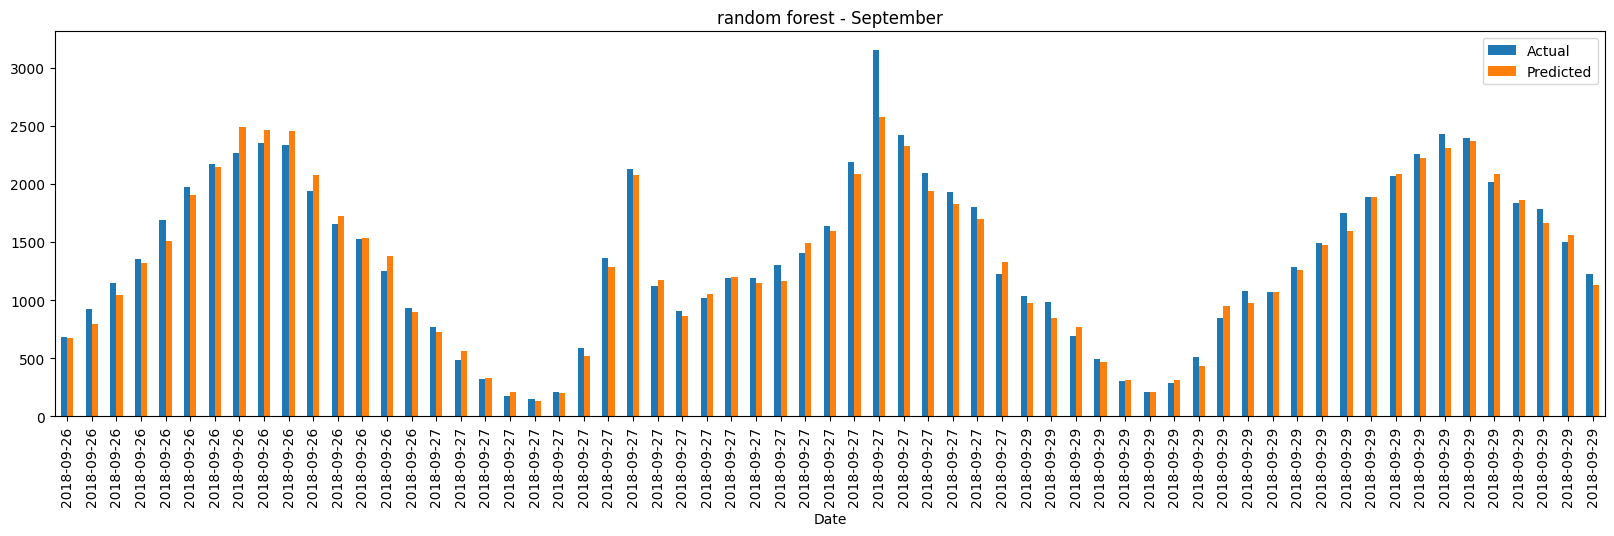

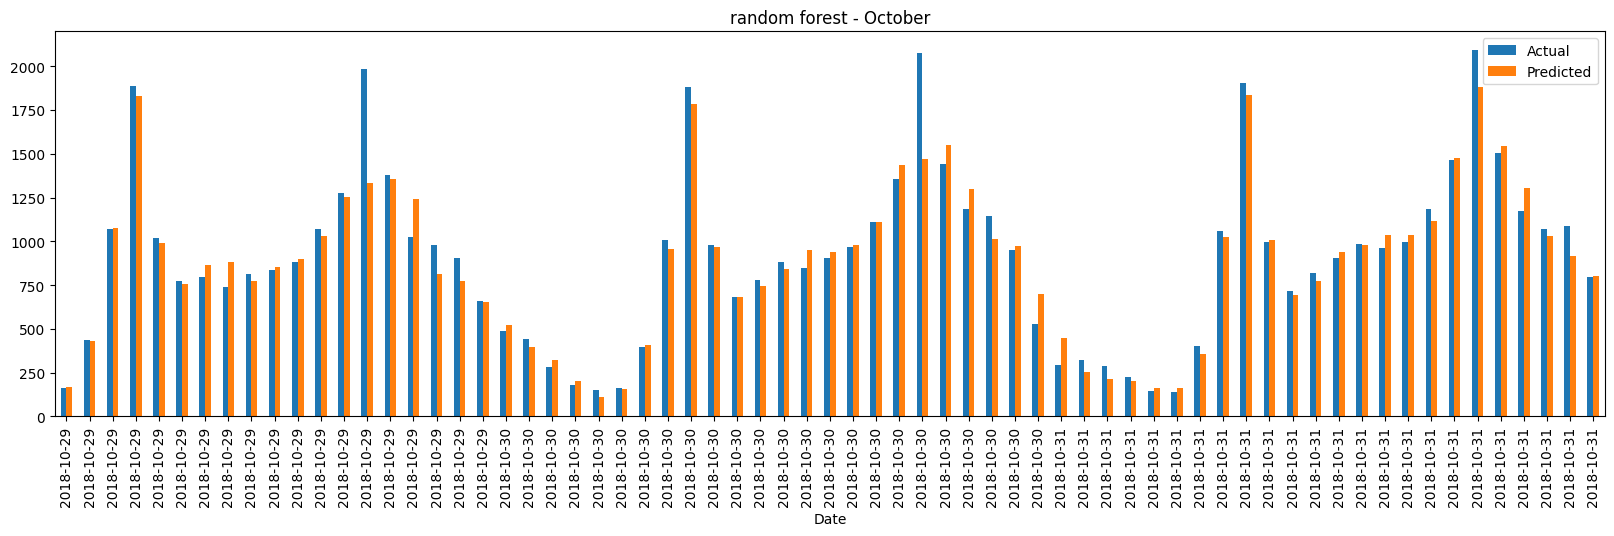

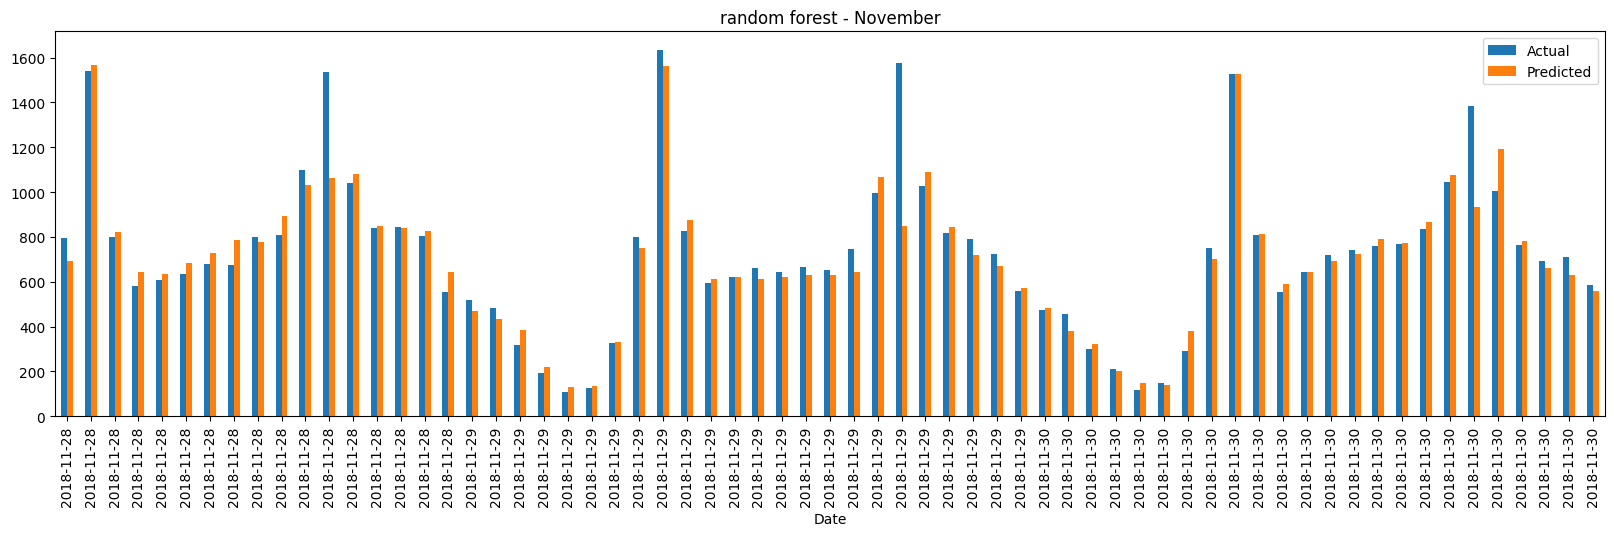

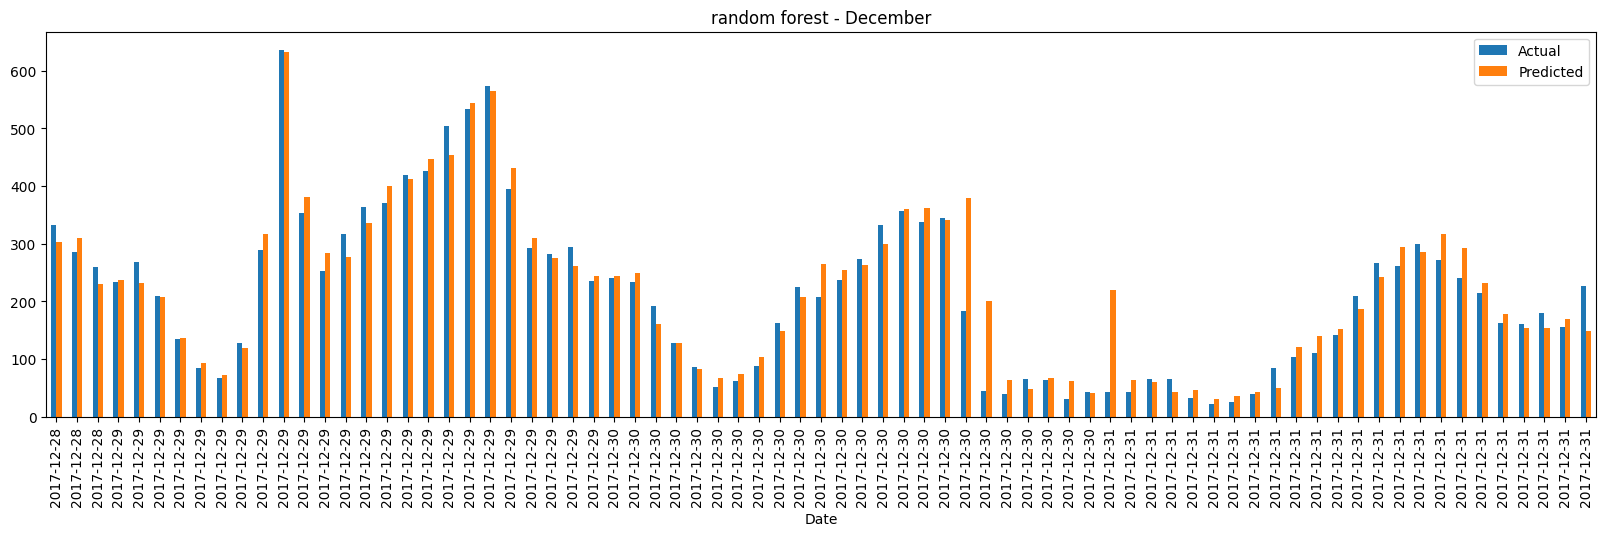

In [27]:
plot_actual_predicted_by_month(y_test, y_pred_rf, 'random forest')

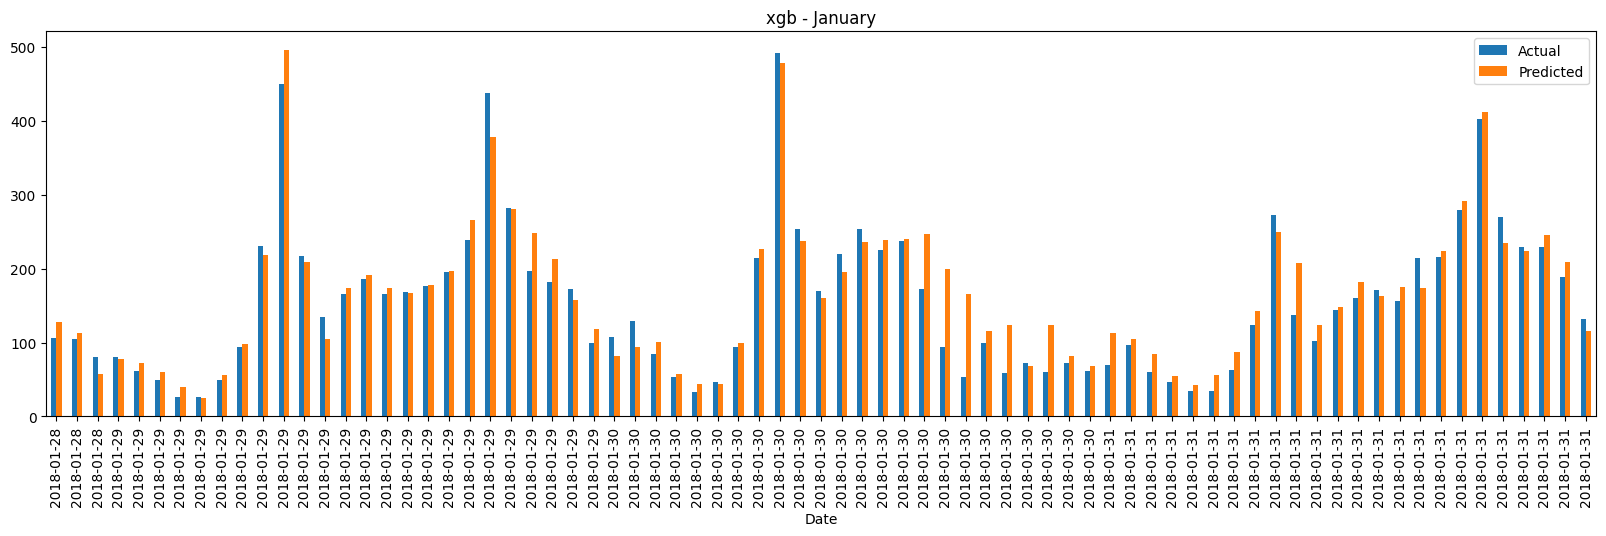

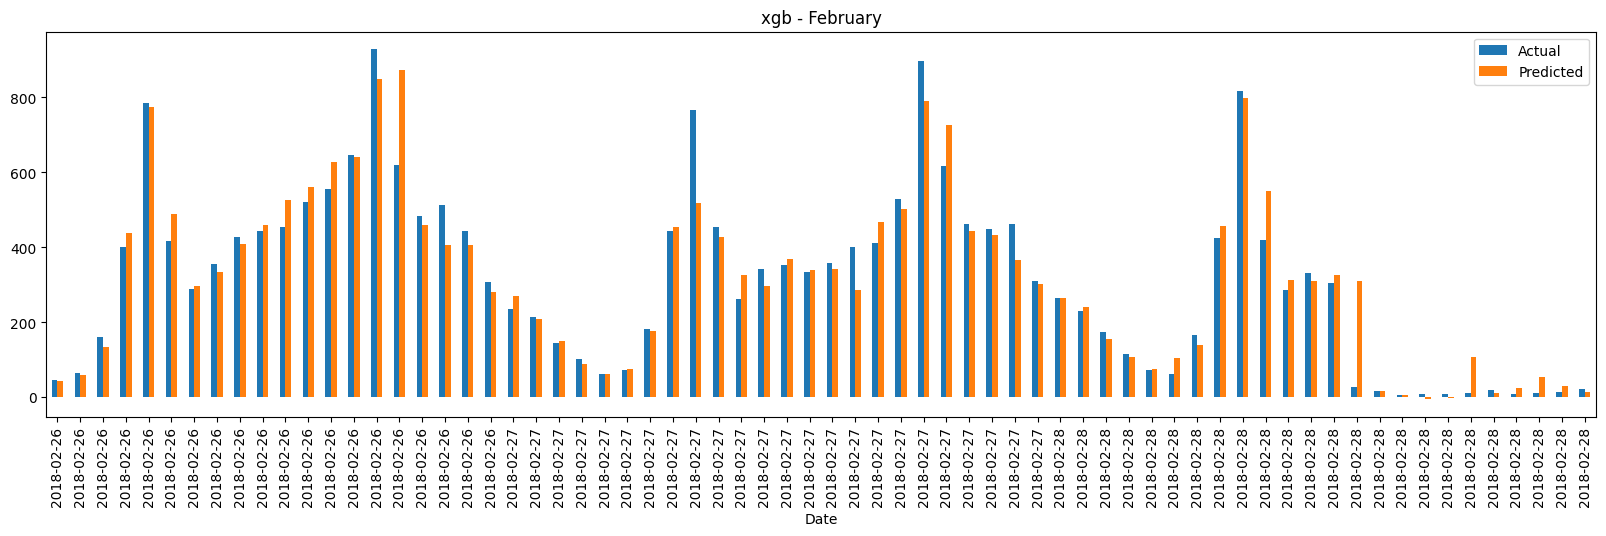

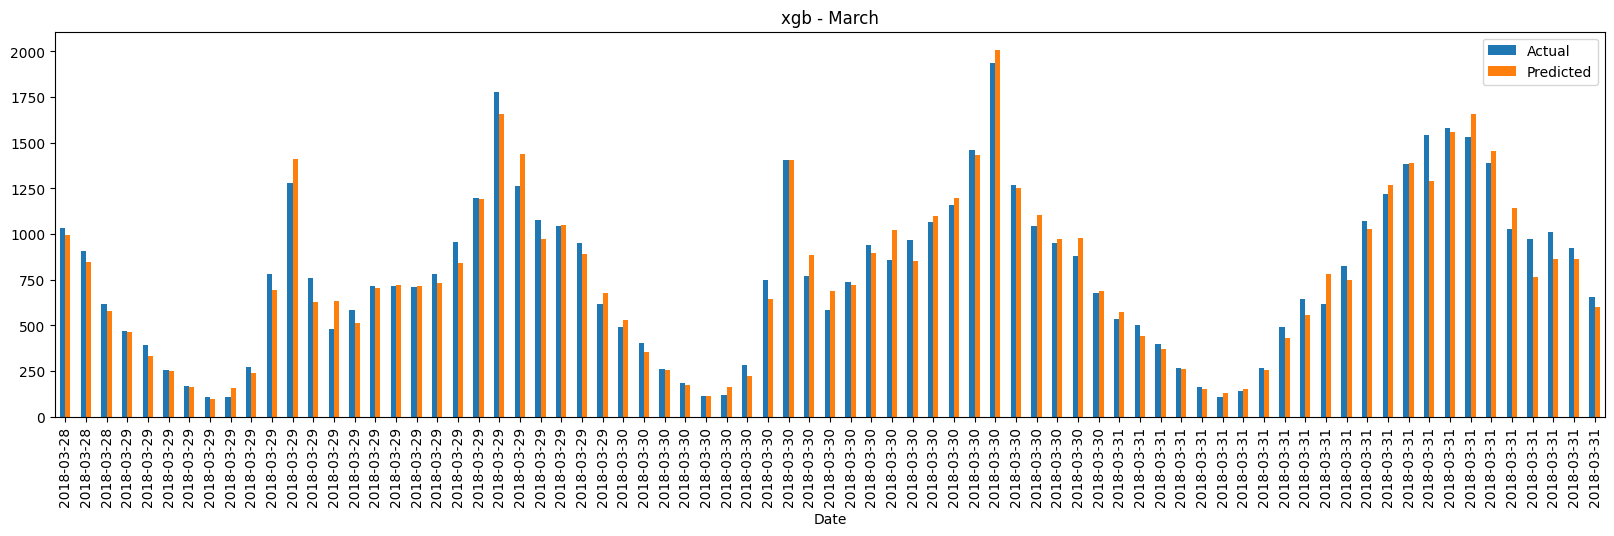

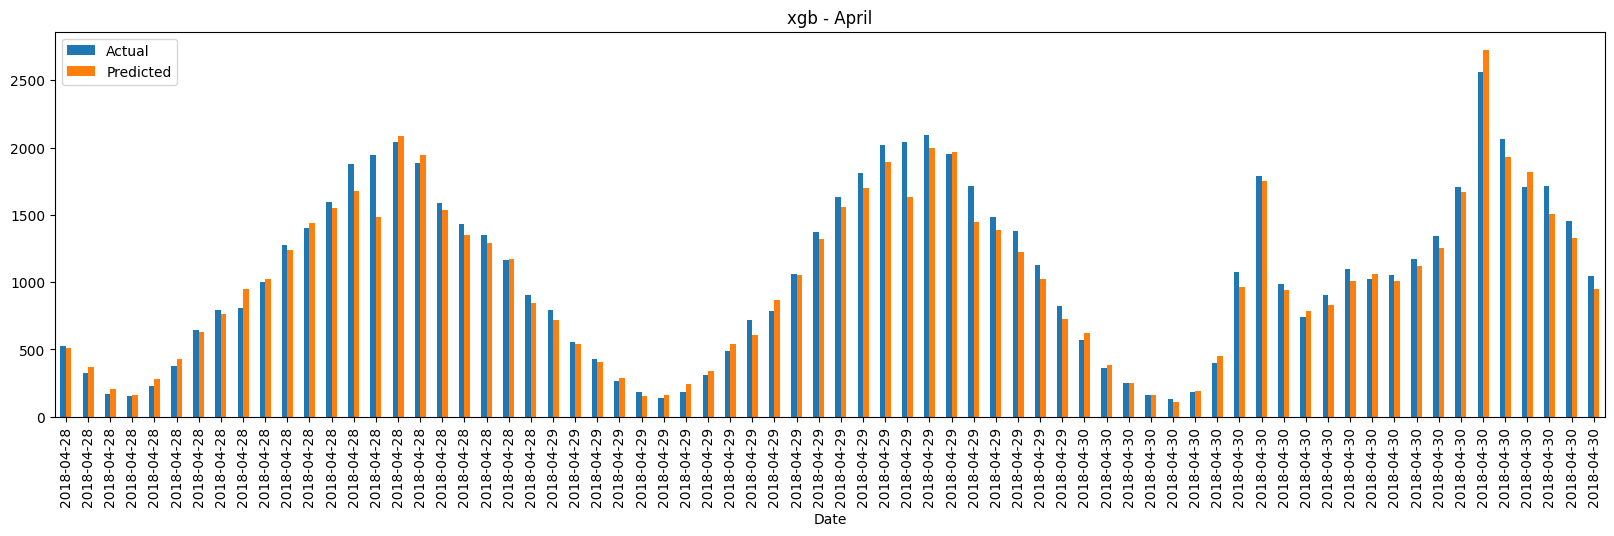

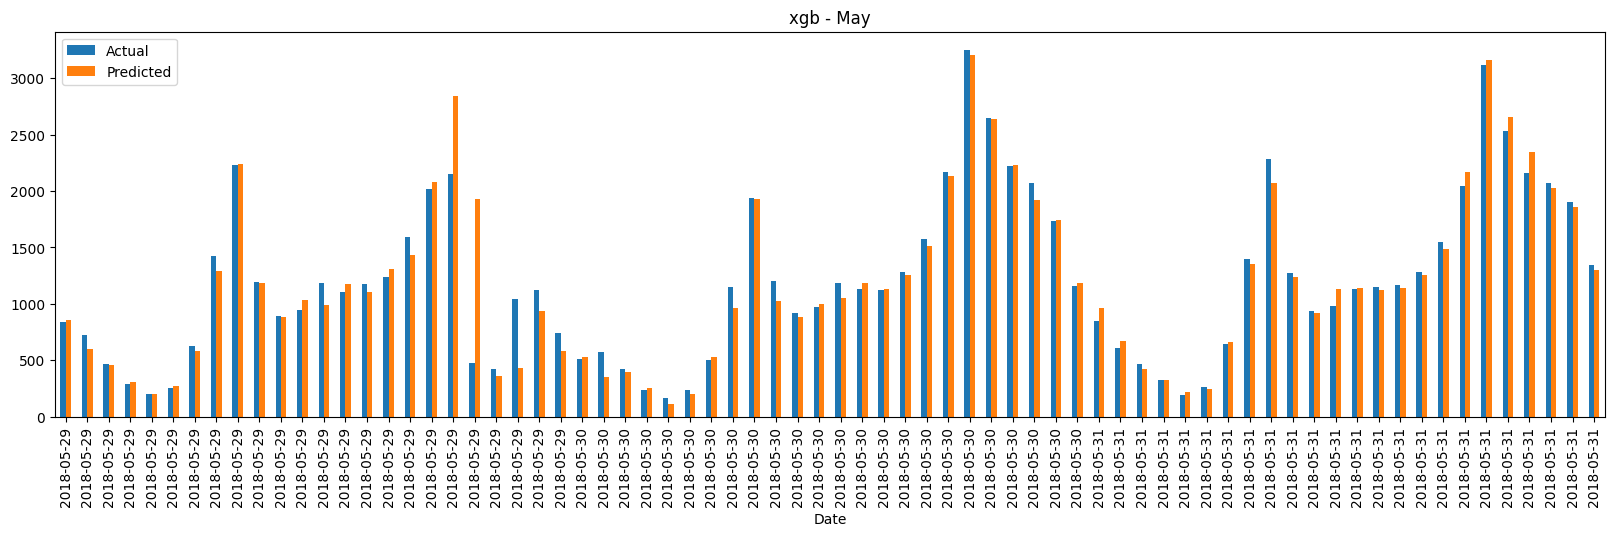

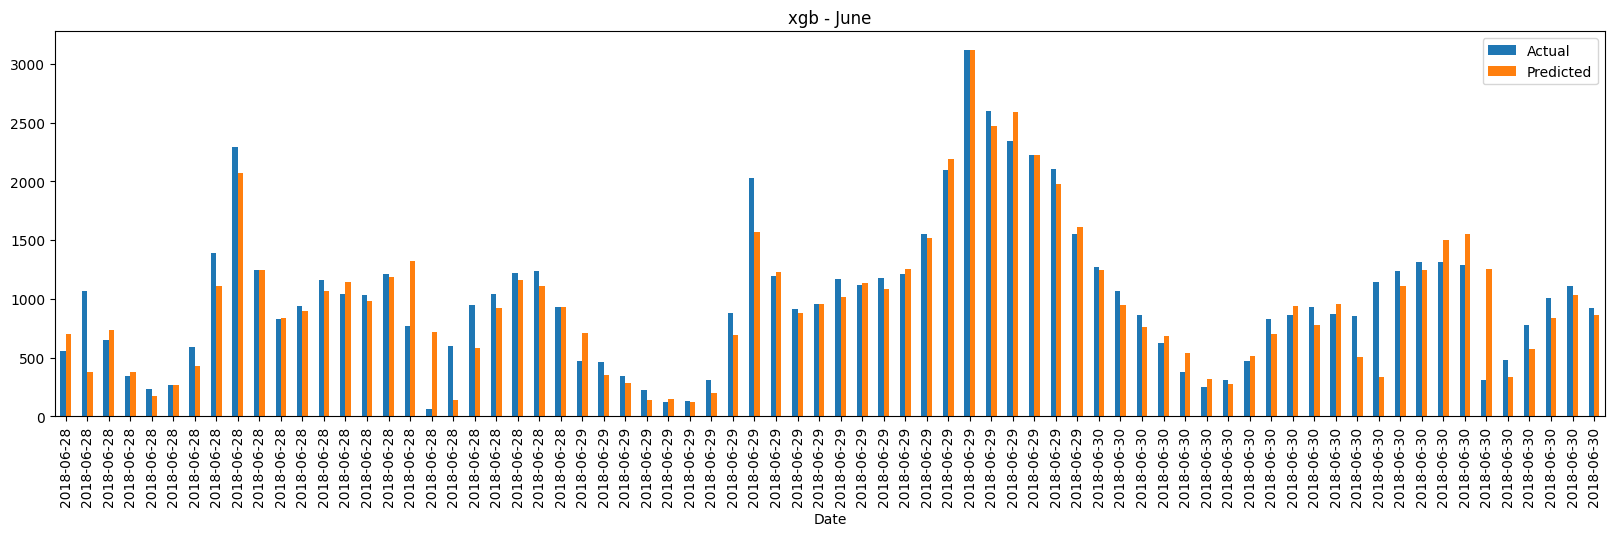

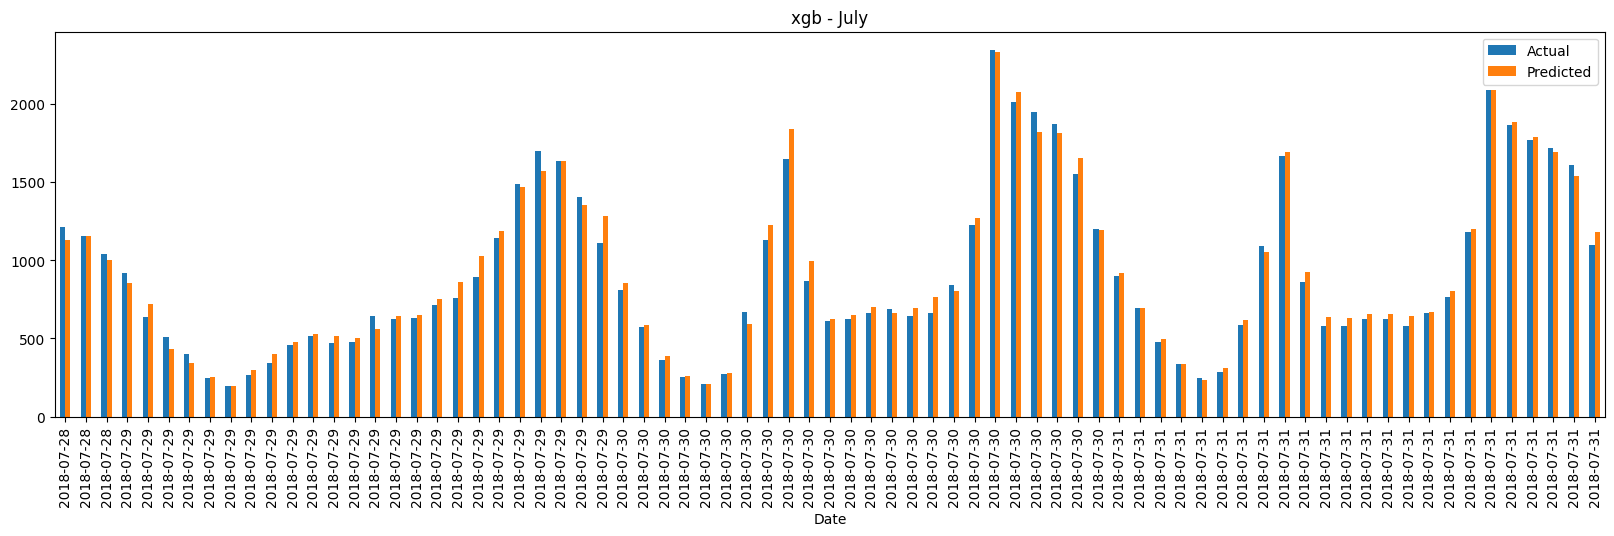

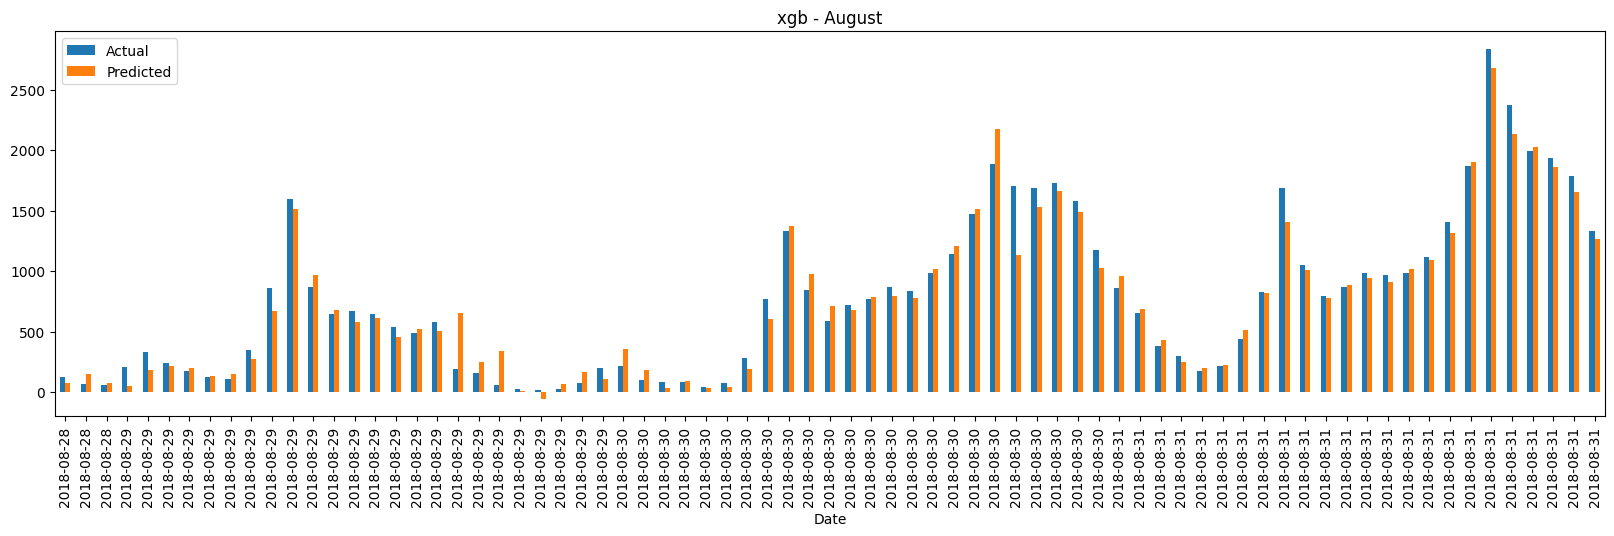

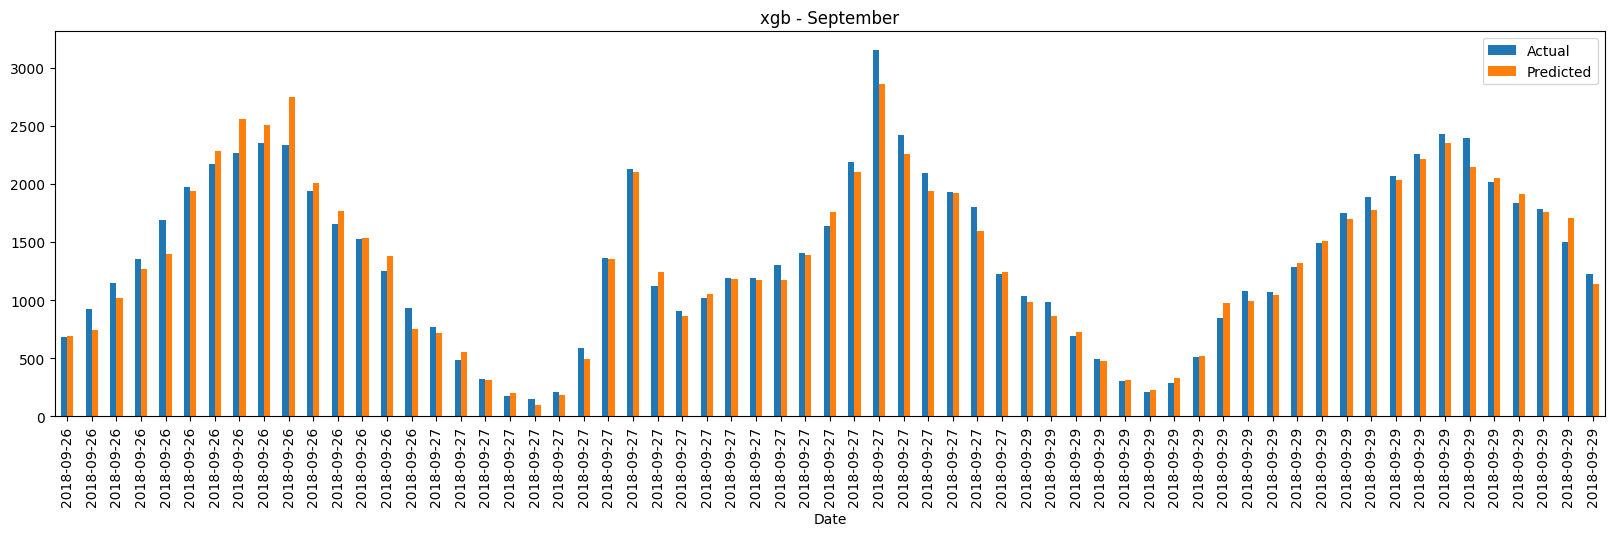

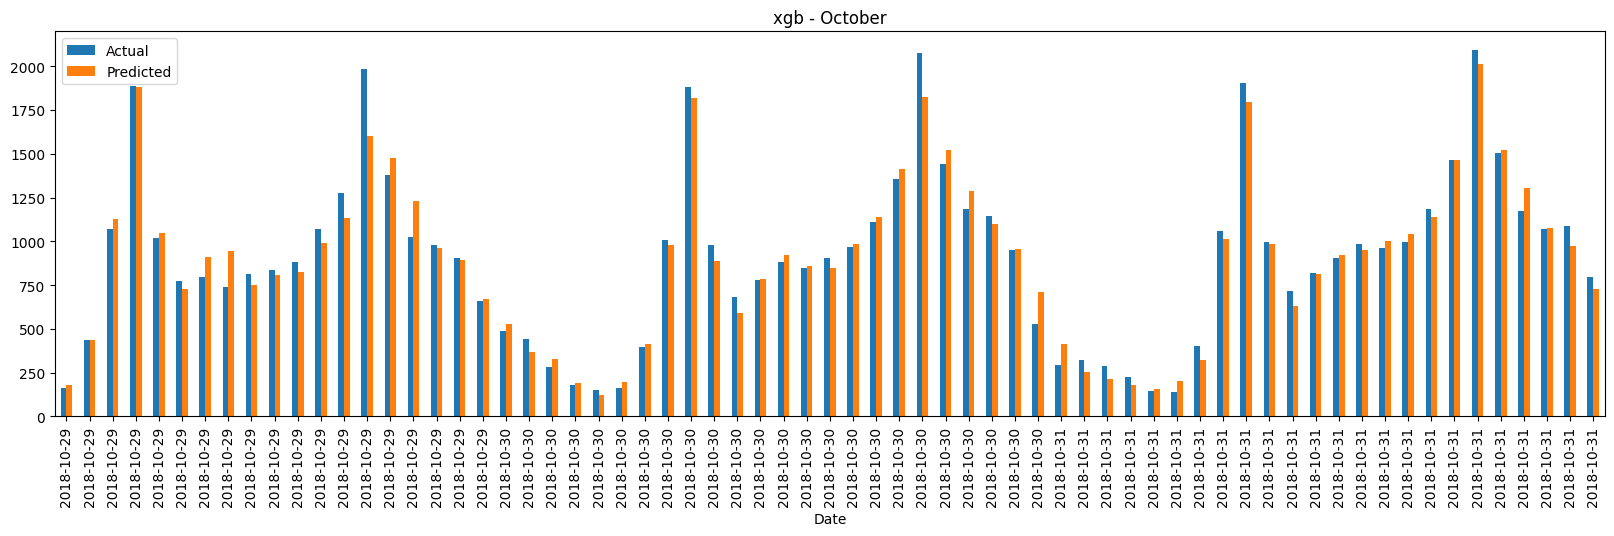

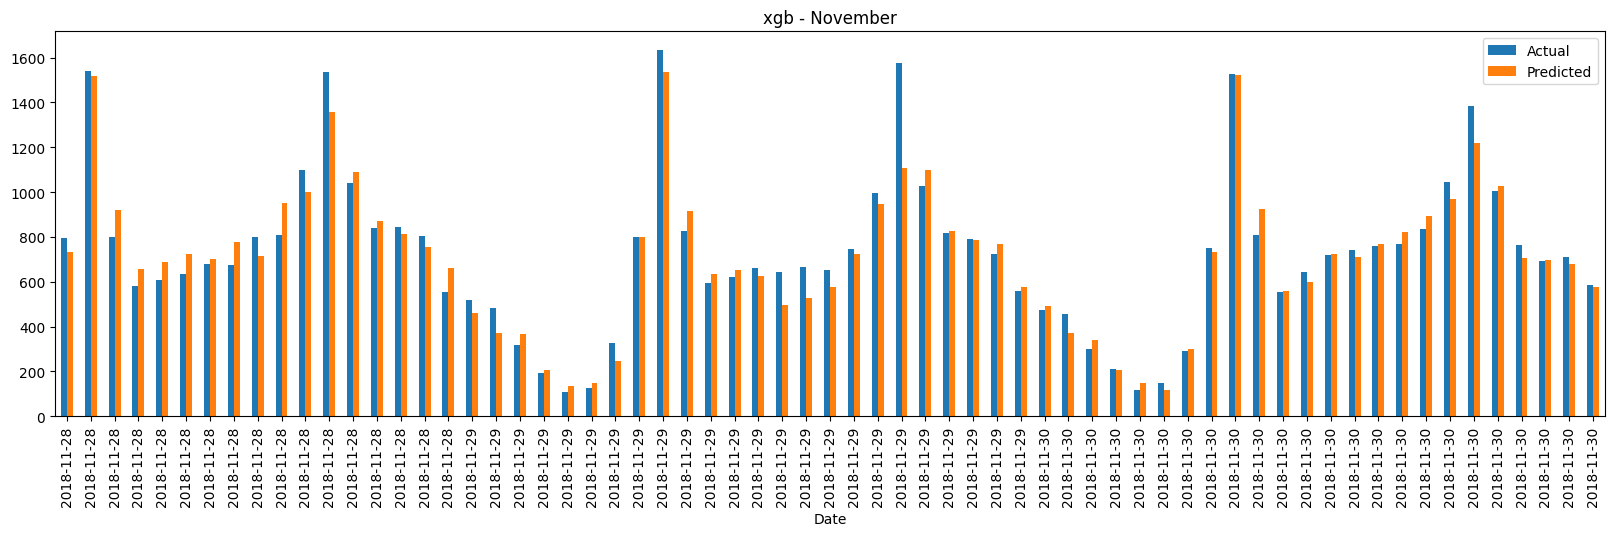

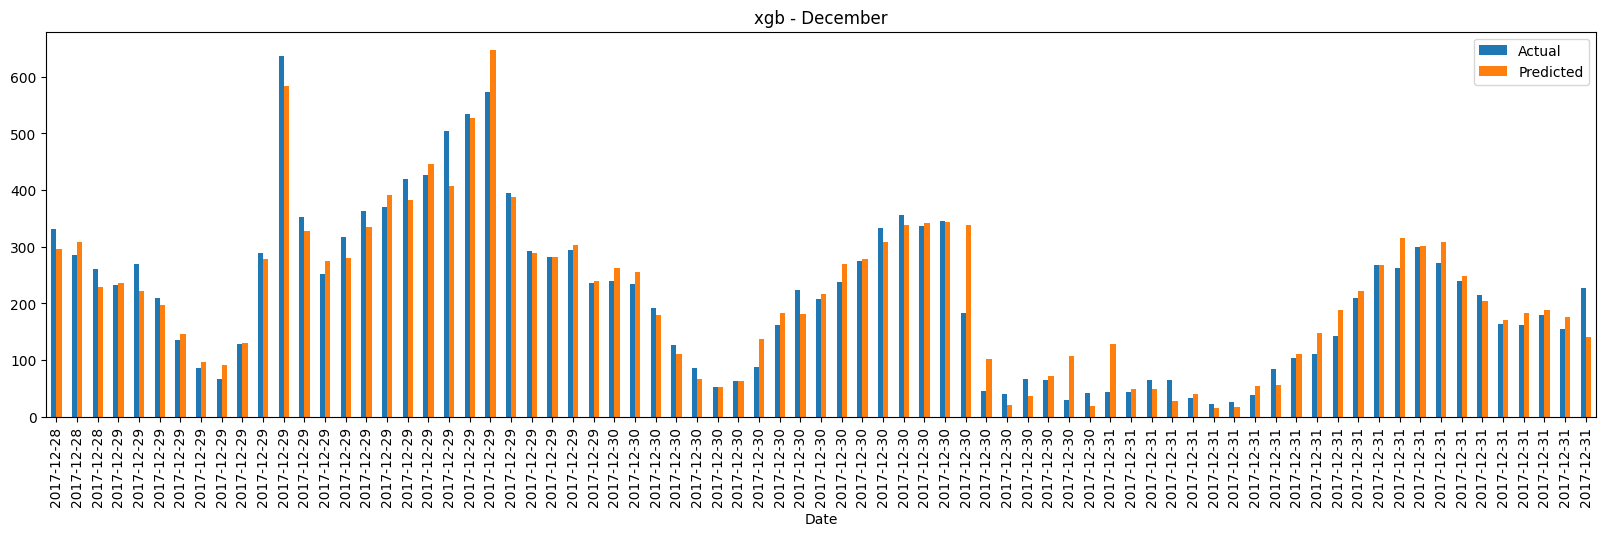

In [28]:
plot_actual_predicted_by_month(y_test, y_pred_xgb, 'xgb')